# 1. 환경 설정 및 데이터 로드

In [22]:
# !pip install pandas matplotlib seaborn wordcloud
# 저는 개인 환경에서 실행해서 설치를 진행하지 않았습니다. (이미 설치되어 있음)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np

In [24]:
# matplotlib 
plt.rcParams['axes.unicode_minus'] = False 

class Config:
    OUTPUT_PROCESSED_DATA_PATH = './dataset/processed_arxiv_data.pkl'

# 데이터 로드
df = pd.read_pickle(Config.OUTPUT_PROCESSED_DATA_PATH)
print(f"> Data loaded successfully. Total records: {len(df)}")


if df is not None:
    print("\n--- Data Head ---")
    print(df[['year', 'time_period', 'title', 'combined_text', 'categories']].head())
    print("\n--- Data Info ---")
    df.info()

> Data loaded successfully. Total records: 34387

--- Data Head ---
   year time_period                             title  \
0  1986   1986-1992  Desperately Seeking Superstrings   
1  1988   1986-1992    Applied Conformal Field Theory   
2  1989   1986-1992      Convex bodies with few faces   
3  1989   1986-1992          Shadows of convex bodies   
4  1989   1986-1992     A note on canonical functions   

                                       combined_text             categories  
0  Desperately Seeking Superstrings. We provide a...  physics.pop-ph hep-th  
1  Applied Conformal Field Theory. These lectures...                 hep-th  
2  Convex bodies with few faces. It is proved tha...        math.MG math.FA  
3  Shadows of convex bodies. It is proved that if...        math.MG math.FA  
4  A note on canonical functions. We construct a ...                math.LO  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34387 entries, 0 to 34386
Data columns (total 20 col

## 2.1. 연도별/시기별 논문 분포 분석 (Trend Base)

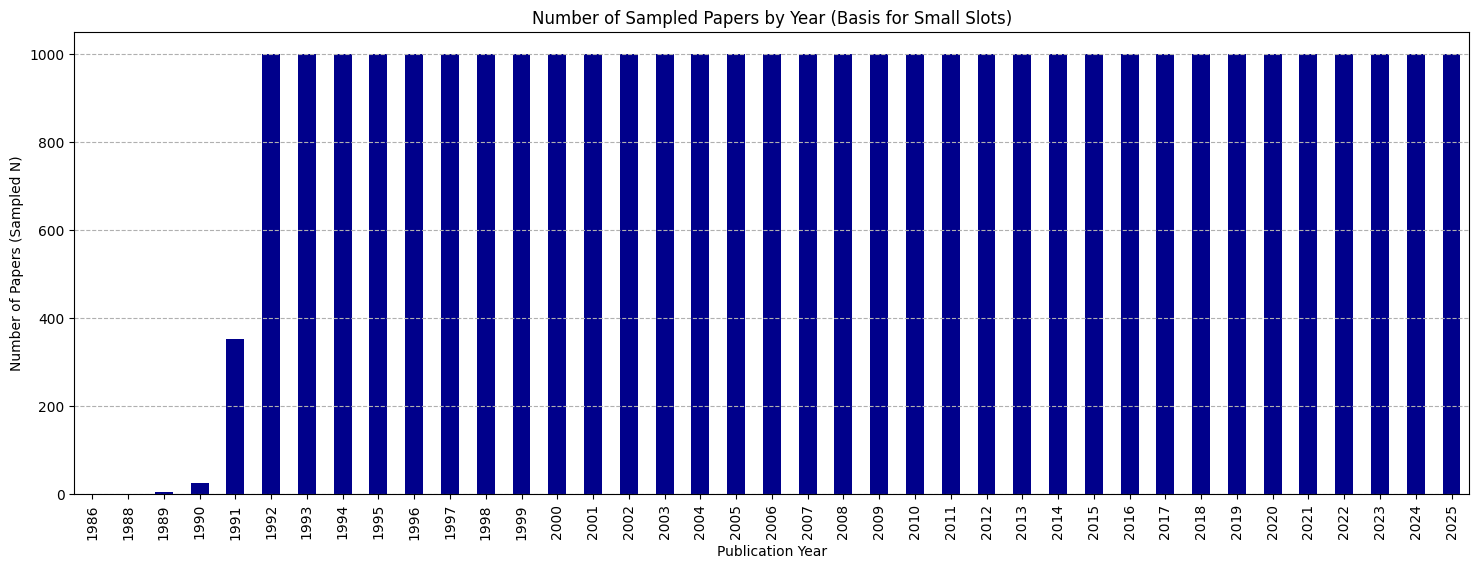

/var/folders/tg/v_32vyl14g5dm3wm3452sjrc0000gn/T/ipykernel_63112/3694889116.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='time_period', data=df, palette='Spectral',


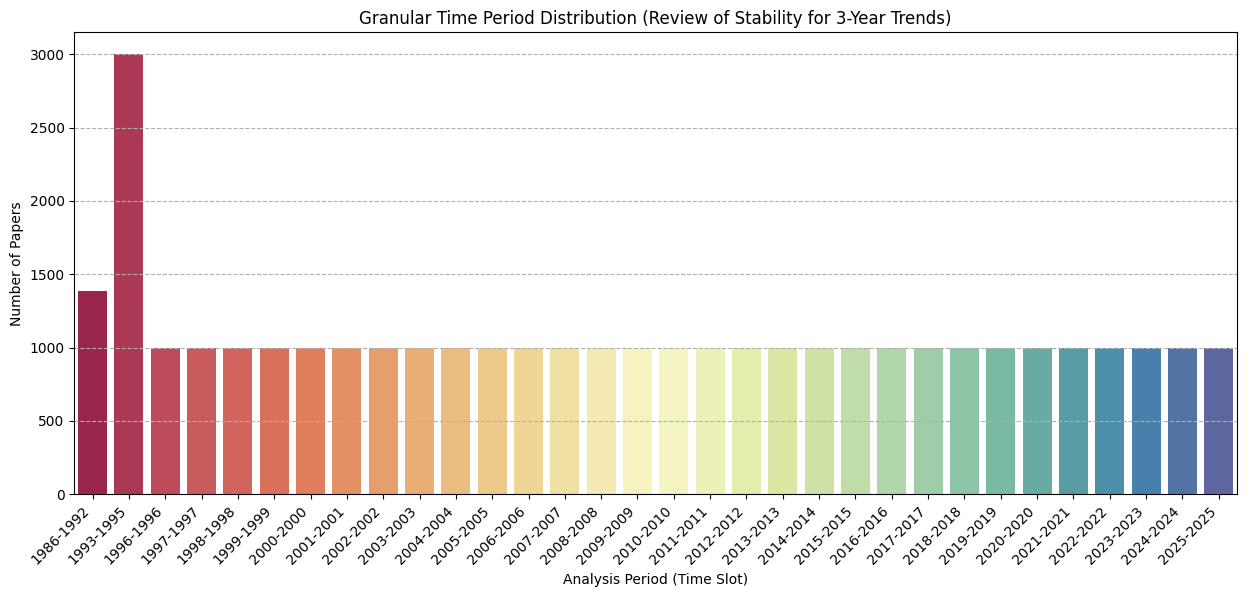

In [25]:
# Year Distribution (Detailed Sampling Result Check) (연도별 분포 (샘플링 결과 상세 확인))
plt.figure(figsize=(18, 6))
df['year'].value_counts().sort_index().plot(kind='bar', color='darkblue')
plt.title('Number of Sampled Papers by Year (Basis for Small Slots)') # 연도별 샘플링된 논문 수 (Small Slot의 기반이 됨)
plt.xlabel('Publication Year') # 발행 연도
plt.ylabel('Number of Papers (Sampled N)') # 논문 수 (샘플링 N)
plt.grid(axis='y', linestyle='--')
plt.show()

# Granular Time Period Distribution (Core Analysis Unit) (세분화된 시기별 분포 (핵심 분석 단위))
plt.figure(figsize=(15, 6))
sns.countplot(x='time_period', data=df, palette='Spectral', 
              order=df['time_period'].value_counts().sort_index().index)
plt.title('Granular Time Period Distribution (Review of Stability for 3-Year Trends)') # 세분화된 시기별 논문 분포 (3년 단위 트렌드 안정성 검토)
plt.xlabel('Analysis Period (Time Slot)') # 분석 시기 (Time Slot)
plt.ylabel('Number of Papers') # 논문 수
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()

## 2.2. 주요 카테고리 분포 분석

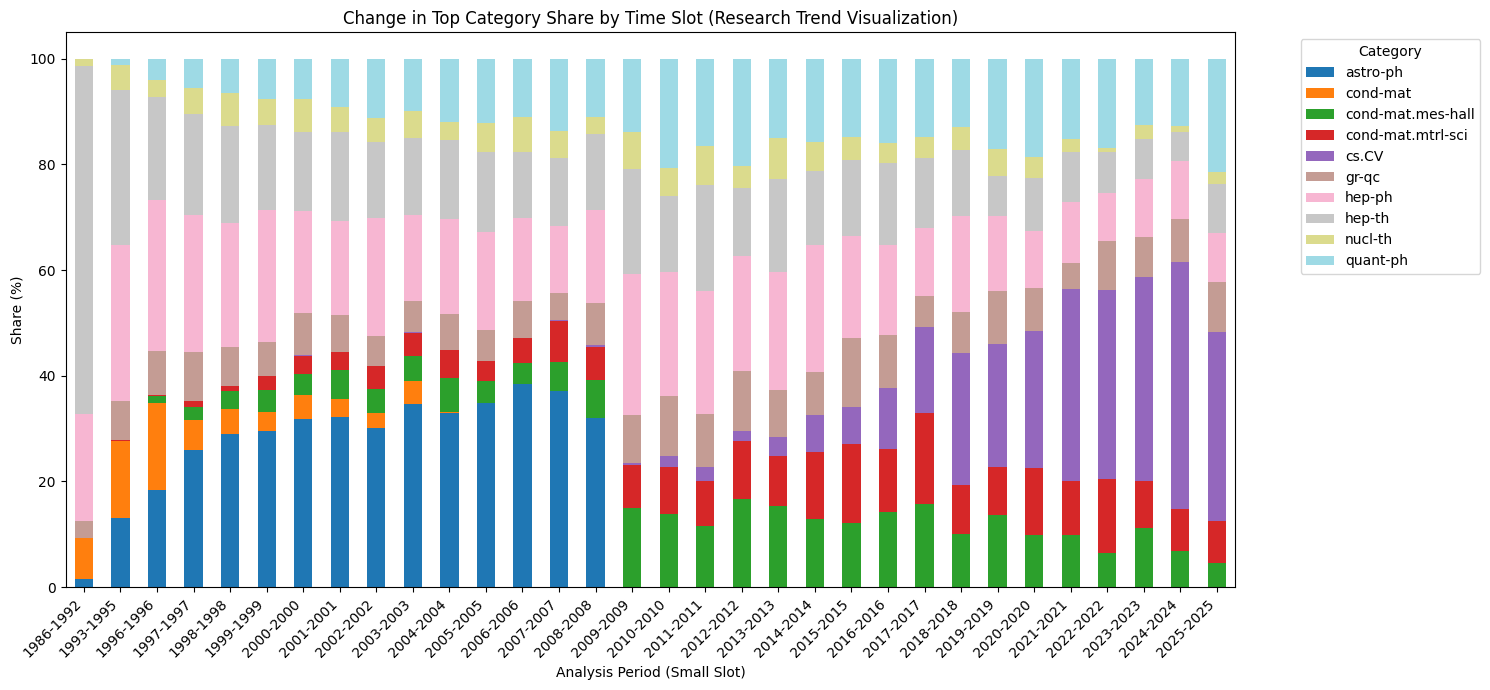

In [26]:
if 'primary_category' not in df.columns:
    print("Warning: 'primary_category' column is missing, creating it temporarily.") # 경고: 'primary_category' 컬럼이 없어 임시로 생성합니다.
    df['primary_category'] = df['categories'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)

# Extract top 10 categories (상위 10개 카테고리 추출)
top_categories = df['primary_category'].value_counts().nlargest(10).index
df_top_cat = df[df['primary_category'].isin(top_categories)]

# Calculate normalized category share per time period (시기별 정규화된 카테고리 점유율 계산)
cat_time_pivot = df_top_cat.groupby(['time_period', 'primary_category']).size().unstack(fill_value=0)
cat_time_pivot_norm = cat_time_pivot.div(cat_time_pivot.sum(axis=1), axis=0) * 100

# Plot Stacked Bar Chart
cat_time_pivot_norm.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='tab20')
plt.title('Change in Top Category Share by Time Slot (Research Trend Visualization)') # 타임 슬롯별 상위 카테고리 점유율 변화 (연구 동향 시각화)
plt.xlabel('Analysis Period (Small Slot)') # 분석 시기 (Small Slot)
plt.ylabel('Share (%)') # 점유율 (%)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# It is valuable to focus on analyzing the trend of the most frequent categories
# (가장 많은 카테고리의 트렌드를 집중적으로 분석할 가치가 있음)

## 3.1. 텍스트 길이 분석

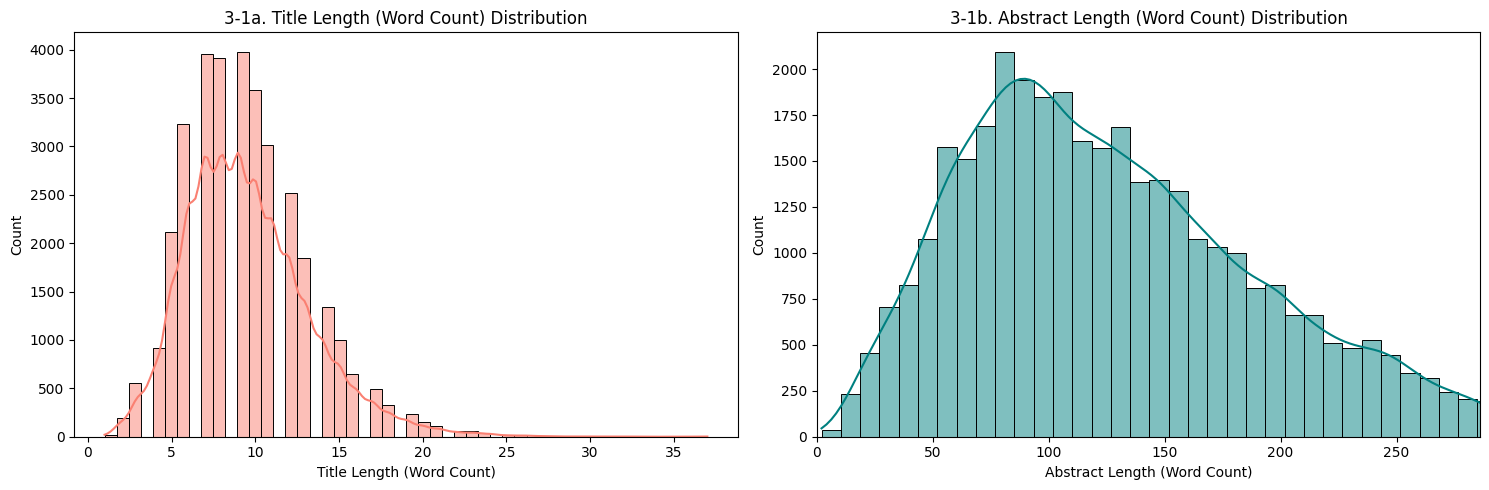

In [27]:
# Calculate text length (based on word count) (텍스트 길이 계산 (단어 수 기준))
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))
df['abstract_length'] = df['abstract'].apply(lambda x: len(str(x).split()))

# Check distribution with histogram (히스토그램으로 분포 확인)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['title_length'], bins=50, kde=True, ax=axes[0], color='salmon')
axes[0].set_title('3-1a. Title Length (Word Count) Distribution') # 제목 길이 (단어 수) 분포
axes[0].set_xlabel('Title Length (Word Count)') # 제목 길이 (단어 수)

sns.histplot(df['abstract_length'], bins=50, kde=True, ax=axes[1], color='teal')
axes[1].set_title('3-1b. Abstract Length (Word Count) Distribution') # 초록 길이 (단어 수) 분포
axes[1].set_xlabel('Abstract Length (Word Count)') # 초록 길이 (단어 수)

# Visualize 99% range after removing extreme outliers from abstract length (초록 길이는 극단적인 이상치 제거 후 99% 구간만 시각화)
abstract_limit = df['abstract_length'].quantile(0.99)
axes[1].set_xlim(0, abstract_limit)

plt.tight_layout()
plt.show()

## 3-2. 가중치 기반 키워드 분석 (토픽 라벨링 준비)

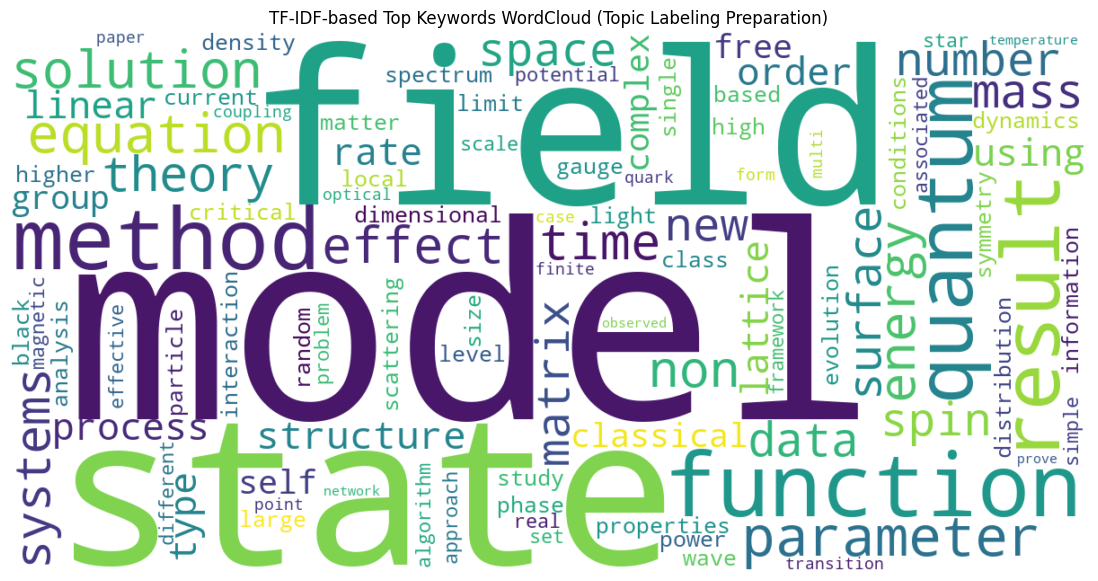

In [28]:
if 'top_keywords_str' in df.columns:    
    # Use only top TF-IDF keywords (already created in the preprocessing step) (TF-IDF 기반 상위 키워드만 사용 (이미 전처리 단계에서 생성됨))
    all_keywords = ' '.join(df['top_keywords_str'].fillna('').tolist())

    # Generate WordCloud (워드클라우드 생성)
    wordcloud = WordCloud(
        width=1200, 
        height=600, 
        background_color='white', 
        # font_path='malgun', # Font path. Removed to fix OSError. (폰트 경로. OSError 해결을 위해 제거됨.)
        max_words=100
    ).generate(all_keywords)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('TF-IDF-based Top Keywords WordCloud (Topic Labeling Preparation)') # TF-IDF 기반 상위 키워드 워드 클라우드 (토픽 라벨링 준비)
    plt.show()

else:
    print("\nWarning: Cannot perform weight-based keyword analysis because 'top_keywords_str' column is missing.") # 경고: 'top_keywords_str' 컬럼이 없어 가중치 기반 키워드 분석을 진행할 수 없습니다.
    print("Substituting with frequency-based WordCloud using the entire raw text.") # 원문 텍스트 전체를 사용하는 빈도 기반 워드 클라우드로 대체합니다.
    
    # Alternative option: Use raw text (previous code approach) (대체 옵션: 원문 텍스트 사용 (이전 코드 방식))
    # Stopwords set similar to those used in TfidfVectorizer (불용어는 TfidfVectorizer에서 사용된 것과 유사하게 설정)
    stopwords = set(["using", "based", "new", "method", "model", "analysis", "paper", "results", "approach", "study", "problem", "different", "proposed", "show", "data", "can", "may", "which", "will"])
    text_content = ' '.join(df['combined_text'].fillna('').tolist()).lower()

    wordcloud = WordCloud(
        width=1000, 
        height=500, 
        background_color='white', 
        # font_path='malgun', # Font path. Removed to fix OSError. (폰트 경로. OSError 해결을 위해 제거됨.)
        stopwords=stopwords
    ).generate(text_content)
    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Raw Text-based Keywords WordCloud (Alternative)') # 원문 기반 키워드 워드 클라우드 (대체)
    plt.show()